<a href="https://colab.research.google.com/github/gamesMum/ChineseSignsClassification/blob/master/Signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Test for CUDA**

In [9]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


1. Upload zip file signs.zip to 'My Drive' 
2. Mount your drive using code below. 

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


 3. Unzip the file:



You just unziped your folder. Take a look at the structure, and pictures

In [4]:
!unzip "/content/drive/My Drive/signs.zip" -d "sign"

Archive:  /content/drive/My Drive/signs.zip
   creating: sign/signs/
   creating: sign/signs/valid/
   creating: sign/signs/valid/pig/
  inflating: sign/signs/valid/pig/00000563.jpg  
  inflating: sign/signs/valid/pig/00000205.jpg  
  inflating: sign/signs/valid/pig/00000211.jpg  
  inflating: sign/signs/valid/pig/00000577.jpg  
  inflating: sign/signs/valid/pig/00000588.jpg  
  inflating: sign/signs/valid/pig/00000742.jpeg  
  inflating: sign/signs/valid/pig/00000589.jpg  
  inflating: sign/signs/valid/pig/00000210.jpg  
  inflating: sign/signs/valid/pig/00000576.jpg  
  inflating: sign/signs/valid/pig/00000562.jpg  
  inflating: sign/signs/valid/pig/00000238.jpg  
  inflating: sign/signs/valid/pig/00000200.jpeg  
  inflating: sign/signs/valid/pig/00000650.jpeg  
  inflating: sign/signs/valid/pig/00000012.jpg  
  inflating: sign/signs/valid/pig/00000760.jpg  
  inflating: sign/signs/valid/pig/00000199.jpg  
  inflating: sign/signs/valid/pig/00000600.jpg  
  inflating: sign/signs/valid

In [0]:
import os
os.chdir("/content/sign/")

In [7]:
#Download nonchuks library to remove corrupted images
!pip install nonechucks

  Created wheel for nonechucks: filename=nonechucks-0.4.0-cp36-none-any.whl size=11546 sha256=07ba93b6232cacfc9528828a1770ad957b6ea5b9acaae234a24a2c14409c5a68
  Stored in directory: /root/.cache/pip/wheels/00/b3/4e/4e30d5f934293de9abab2bfe6a4ce6fe77bf936c625133dd9c
Successfully built nonechucks


In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np

import matplotlib.pyplot as plt
import nonechucks as nc
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models


nonechucks may not work properly with this version of PyTorch (1.3.1). It has only been tested on PyTorch versions 1.0, 1.1, and 1.2


Define transforms, rezise, rotate slightly, preform horizontal flip

In [0]:

data_dir = 'signs'

batch_size = 64
# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.Resize((256, 256)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])])

test_transforms = transforms.Compose([transforms.Resize(256, 256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
valid_data = datasets.ImageFolder(data_dir + "/valid", transform=transforms )

train_data = nc.SafeDataset(train_data)
test_data = nc.SafeDataset(test_data)
valid_data = nc.SafeDataset(valid_data)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)

# specify the image classes
classes = ['dog', 'dragon', 'goat', 'horse', 'monkey', 'ox', 'pig', 'rabbit', 
           'ratt', 'rooster', 'snake', 'tiger']

### Visualize a Batch of Training Data

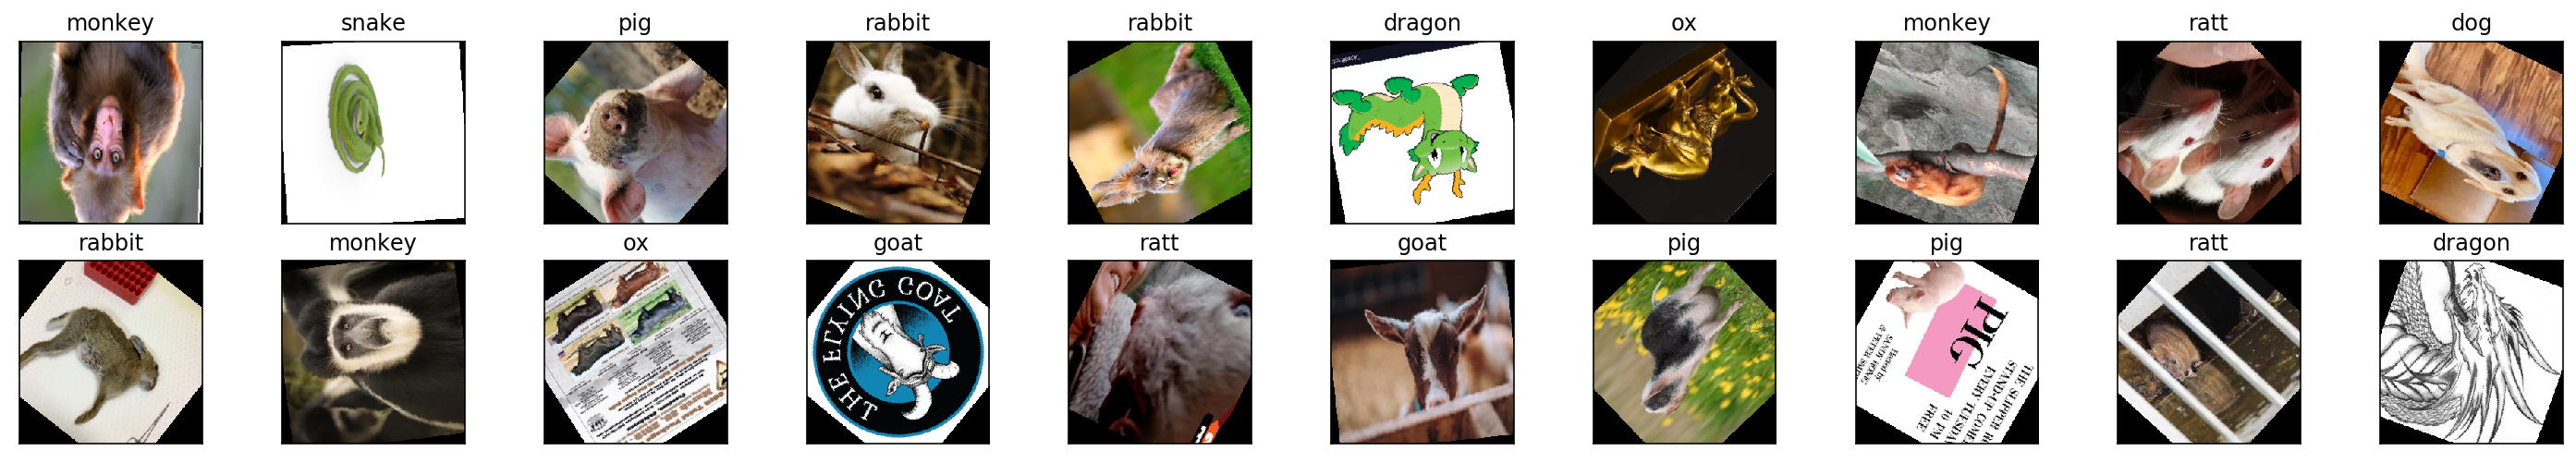

In [11]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])
  

# **Build The Model**

________________________________

In [12]:
import torch.nn as nn
import torch.nn.functional as FF

#Define the CNN architecture
class Net(nn.Module):
  def __init__(self):
      super(Net, self).__init__()
      # convolutional layer (sees 256 * 256 * 3 image tensor)
      self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
      # convolutional layer (sees 128 * 128 * 16 tensor)
      self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
      # convolutional layer (sees 64 * 64 * 32 tensor)
      self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
      # max pooling layer
      self.pool = nn.MaxPool2d(2, 2)
      # linear layer (64 * 32 * 32 -> 500)
      self.fc1 = nn.Linear(64 * 32 * 32, 500)
      # linear layer (500 -> 10)
      self.fc2 = nn.Linear(500, 12)
      # dropout layer (p=0.25)
      self.dropout = nn.Dropout(0.25)
  
  def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 32 * 32)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=12, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


Define the optimizer and the error function

In [0]:
import torch.optim as optim
#the loss function
criterion = nn.CrossEntropyLoss()

#the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

# **Training**

In [0]:
# number of epochs to train the model
import numpy as np
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (images, labels) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the batch loss
        loss = criterion(output, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*images.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (images, labels) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the batch loss
        loss = criterion(output, labels)
        # update average validation loss 
        valid_loss += loss.item()*images.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_augmented.pt')
        valid_loss_min = valid_loss

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
